In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from pathlib import Path

import itertools
from functools import partial

DATA_DIR = Path("/content/drive/My Drive/SH/report/data")
NUM_SUBGOALS = 10

tf.keras.backend.clear_session()
tf.__version__

'2.2.0-rc3'

In [103]:
# Radial basis activation function: e^(-x^2)
@tf.function
def rbf(x):
    return tf.exp(-tf.pow(x, 2))

# Define model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1,
                          use_bias=False,
                          input_shape=(2,),
                          activation=rbf)
])

initial_weights = np.array([1, 1])[:, np.newaxis].astype(np.float32)
model.weights[0].assign(tf.constant(initial_weights))
model.get_weights()

[array([[1.],
        [1.]], dtype=float32)]

In [0]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(0.1, 0), metrics=["accuracy"])
#model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

In [105]:
y = np.array([
    1,
    rbf(2.),
    rbf(2.)
])
x = np.array([
    (2, 2),
    (2, 0),
    (0, 2)
])
x, y

(array([[2, 2],
        [2, 0],
        [0, 2]]), array([1.        , 0.01831564, 0.01831564]))

In [106]:
def compute_subgoals(initial, goal, N, model, x):
    WEIGHTS_SHAPE = list(map(tf.shape, model.get_weights()))

    def get_weights():
        return tf.concat([tf.reshape(x, [-1]) for x in model.get_weights()], axis=0)

    def set_weights(weights):
        if WEIGHTS_SHAPE is None:
            get_weights()

        weights = tf.split(weights, list(map(tf.reduce_prod, WEIGHTS_SHAPE)))
        weights = [tf.reshape(x, shape) for (x, shape) in zip(weights, WEIGHTS_SHAPE)]
        model.set_weights(weights)
    
    def predict_for_weights(weights, x):
        set_weights(weights)
        return model.predict(x)

    subgoal_weights = tf.expand_dims(tf.linspace(0., 1, N), axis=-1) * (goal - initial) + initial

    subgoals = tf.stack([predict_for_weights(weights, x) for weights in subgoal_weights])
    subgoals = tf.squeeze(subgoals)
    
    return subgoal_weights, subgoals


initial = tf.constant([1., 1])
goal = tf.constant([1., -1])
N = NUM_SUBGOALS + 1 # number of subgoals

weights, subgoals = compute_subgoals(initial, goal, N, model, x)

subgoals

<tf.Tensor: shape=(11, 3), dtype=float32, numpy=
array([[1.12535176e-07, 1.83156393e-02, 1.83156393e-02],
       [2.35257721e-06, 1.83156393e-02, 7.73047283e-02],
       [3.57128229e-05, 1.83156393e-02, 2.36927733e-01],
       [3.93669179e-04, 1.83156393e-02, 5.27292430e-01],
       [3.15111061e-03, 1.83156393e-02, 8.52143764e-01],
       [1.83156393e-02, 1.83156393e-02, 1.00000000e+00],
       [7.73047656e-02, 1.83156393e-02, 8.52143705e-01],
       [2.36927733e-01, 1.83156393e-02, 5.27292430e-01],
       [5.27292430e-01, 1.83156393e-02, 2.36927733e-01],
       [8.52143824e-01, 1.83156393e-02, 7.73047060e-02],
       [1.00000000e+00, 1.83156393e-02, 1.83156393e-02]], dtype=float32)>

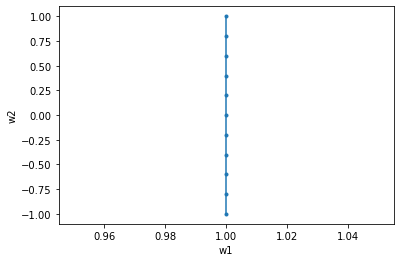

In [107]:
fig, ax = plt.subplots()
ax.set_xlabel("w1")
ax.set_ylabel("w2")
ax.plot(weights[..., 0], weights[..., 1], '.-')

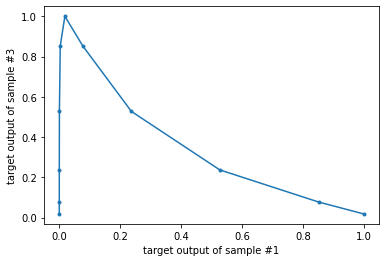

In [108]:
# Let's plot the output space
# Note that two of the samples stay constant throughout. This actually comes in quite handy because we only need a 2D plot to visualize output space instead of a 4D plot.
fig, ax = plt.subplots()
ax.set_xlabel("target output of sample #1")
ax.set_ylabel("target output of sample #3")
ax.plot(subgoals[..., 0], subgoals[..., 2], '.-')

In [109]:
initial_weights = [1, 1]
model.weights[0].assign(tf.constant(np.array(initial_weights).reshape((2, 1)).astype(np.float32)))

def has_achieved(model, x, subgoals, i):
    #print(tf.norm(tf.squeeze(model.predict(x)) - subgoals[i]), tf.norm(subgoals[i-1] - subgoals[i]))
    return tf.norm(tf.squeeze(model.predict(x)) - subgoals[i]) <= .1 * tf.norm(subgoals[i-1] - subgoals[i])

class EarlyStoppingOnSubgoal(tf.keras.callbacks.Callback):
    def __init__(self, x, subgoals, i):
        self.x = x
        self.subgoals = subgoals
        self.i = i
        self.finished = False
    
    def on_epoch_end(self, epoch, logs=None):
        if has_achieved(self.model, self.x, self.subgoals, self.i):
            self.finished = True
            self.model.stop_training = True
            print(f"stopping after {epoch} epochs")

class TrainingLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        self.predictions = list()
        self.weights = list()
    
    def on_epoch_end(self, epoch, logs=None):
        self.predictions.append(self.model.predict(x))
        self.weights.append(self.model.get_weights())

logger = TrainingLogger()
loss = []
for i in range(1, len(subgoals)):
    print(f"attempting to achieve subgoal #{i}")
    early_stopping = EarlyStoppingOnSubgoal(x, subgoals, i)
    history = model.fit(x, subgoals[i],
                        batch_size=len(subgoals[i]),
                        epochs=5000,
                        callbacks=[logger, early_stopping],
                        verbose=0)
    loss.append(history.history["loss"])
    if not early_stopping.finished:
        break

attempting to achieve subgoal #1
stopping after 331 epochs
attempting to achieve subgoal #2
stopping after 48 epochs
attempting to achieve subgoal #3
stopping after 14 epochs
attempting to achieve subgoal #4
stopping after 12 epochs
attempting to achieve subgoal #5
stopping after 64 epochs
attempting to achieve subgoal #6


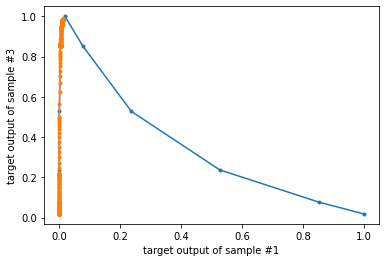

In [110]:
# Let's plot the output space
# Note that two of the samples stay constant throughout. This actually comes in quite handy because we only need a 2D plot to visualize output space instead of a 4D plot.
fig, ax = plt.subplots()
ax.set_xlabel("target output of sample #1")
ax.set_ylabel("target output of sample #3")
ax.plot(subgoals[..., 0], subgoals[..., 2], '.-')

# Plot our predictions
predictions = np.array(logger.predictions).squeeze()
ax.plot(predictions[..., 0], predictions[..., 2], '.-')

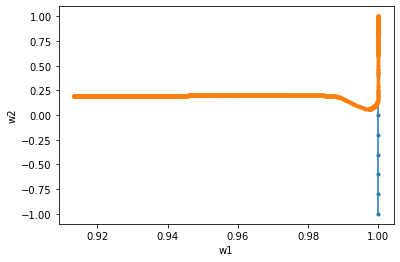

In [111]:
fig, ax = plt.subplots()
ax.set_xlabel("w1")
ax.set_ylabel("w2")
ax.plot(weights[..., 0], weights[..., 1], '.-')

training_weights = np.array(logger.weights).squeeze()
ax.plot(training_weights[..., 0], training_weights[..., 1], '.-')

In [0]:
# Save data

with (DATA_DIR / f"stripe_problem_gradient_descent_{NUM_SUBGOALS}_subgoals__subgoal_weights.dat").open("w") as f:
    for w in weights.numpy():
        f.write("\t".join(map(str, w)) + "\n")

with (DATA_DIR / f"stripe_problem_gradient_descent_{NUM_SUBGOALS}_subgoals__training_weights.dat").open("w") as f:
    size = training_weights.shape[0]
    for w in training_weights:
        f.write("\t".join(map(str, w)) + "\n")

with (DATA_DIR / f"stripe_problem_gradient_descent_{NUM_SUBGOALS}_subgoals__subgoal_outputs.dat").open("w") as f:
    for s in subgoals.numpy():
        s = s[0], s[2]
        f.write("\t".join(map(str, s)) + "\n")

with (DATA_DIR / f"stripe_problem_gradient_descent_{NUM_SUBGOALS}_subgoals__subgoal_outputs_3d.dat").open("w") as f:
    for s in subgoals.numpy():
        f.write("\t".join(map(str, s)) + "\n")

with (DATA_DIR / f"stripe_problem_gradient_descent_{NUM_SUBGOALS}_subgoals__training_outputs.dat").open("w") as f:
    size = predictions.shape[0]
    for s in predictions:
        s = s[0], s[2]
        f.write("\t".join(map(str, s)) + "\n")

with (DATA_DIR / f"stripe_problem_gradient_descent_{NUM_SUBGOALS}_subgoals__training_outputs_3d.dat").open("w") as f:
    size = predictions.shape[0]
    for s in predictions:
        f.write("\t".join(map(str, s)) + "\n")

with (DATA_DIR / f"stripe_problem_gradient_descent_{NUM_SUBGOALS}_subgoals__num_epochs_per_subgoal.dat").open("w") as f:
    for i, n in enumerate(map(len, loss), 1):
        f.write("\t".join(map(str, (i, n))) + "\n")

Text(0, 0.5, 'Loss')

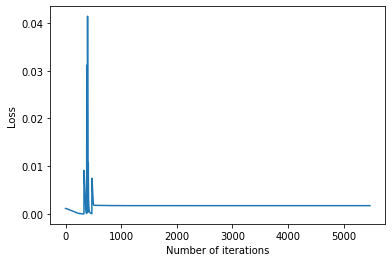

In [113]:
loss_values = list(itertools.chain(*loss))

fig, ax = plt.subplots()
ax.plot(loss_values)
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Loss")